## Gitcoin Grants #14 Trust & DeSoc Scores (🤖,💚)

# Part 1: Data Gathering

This notebook gathers data from Gitcoin Grants and on-chain subgraphs for selected wallets. 

Current sources include: 
- POAPs (xDAI only) // [api](https://api.thegraph.com/subgraphs/name/poap-xyz/poap-xdai)
- Snapshot votes (all EVM chains) // [api](https://hub.snapshot.org/graphql/)
- NFT ownership (ETH Mainnet only) // [api](https://api.zora.co/graphql)
- Lens protocol // [api](https://api.lens.dev/)
- Proof of Humanity // [api](https://api.poh.dev)

### Dependencies

In [1]:
import json
import pandas as pd

from settings import PATHS
from utils.ingest_data import load_transactions
from utils.gqltools import execute_subgraph_query
from utils.subgraphs import query_lens, query_poaps_xdai, query_snapshot
from utils.pypoh import get_raw_set_of_addresses
from utils.zora import query_zora

# 1/ Load GR 14 data and get wallet addresses

This requires access to a private dataset from Gitcoin showing all contributions, squelching & trust bonuses

In [2]:
gr14_rawdata = load_transactions(PATHS['rawdata'])
print(f"Imported {len(gr14_rawdata)} transactions from GR14")
gr14_rawdata.head(1)

Imported 600555 transactions from GR14


,contribution_id,checkout_type,grant_id,is_squelched,trust_bonus,raw_amount_in_token,amount_in_token,amount_to_gitcoin_in_token,token,amount_in_usdt,created_on,modified_on,address
0,2794110,eth_std,5688,True,0.5,0.0047,0.0047,0.0,ETH,5.14943,2022-06-23 23:59:59.976253+00:00,2022-06-24 00:13:33.028389+00:00,0xf6027a84d603b136b5b1ce6896000dca1b35d113


In [3]:
wallets = list(sorted(gr14_rawdata['address'].unique()))
print("Unique wallet addresses:", len(wallets))

whales = gr14_rawdata.groupby('address')['amount_in_usdt'].sum()
whales = list(whales[whales > 10000].index)

drop_wallets = [w for w in wallets if w in whales]
wallets = [w for w in wallets if w not in drop_wallets]
print("Valid wallet addresses:", len(wallets))

Unique wallet addresses: 57522
Valid wallet addresses: 57513


# 2/ Quadratic Funder Score

Create a "score" that rewards going wide over going deep

$${\displaystyle Quadratic Funder Score = (\sum _{i=1}^{n} \sqrt {c}_{i} ) }$$

In [6]:
qf_scores = (gr14_rawdata
             .query("address not in @drop_wallets")
             .groupby(['address', 'grant_id'])['amount_in_usdt']
             .agg(lambda x: sum(x)**.5)
             .reset_index()
             .groupby('address')['amount_in_usdt']                 
             .agg(['count', 'sum'])
            )
qf_scores['qfScore'] = qf_scores['sum'] # ** 2
qf_scores.sort_values(by='qfScore')

,count,sum,qfScore
address,,,
0x43086ff3aeacda9091bef71ffe7a3f22fde5e0e0,13,0.000000,0.000000
0xdf8fe059b7b9f0fb3165f2dcbd5c410f8b854621,1,0.223607,0.223607
0x716fdf3096cb742c581098b17e4f1f458b3a5e04,1,0.226924,0.226924
0x8f72866c7eb66e038b5470d84281f0c2dded74fb,1,0.247523,0.247523
0x677e563ba5dd39165b982d23ee54aaa3b6d63776,1,0.322675,0.322675
...,...,...,...
0x0e3c371c4c8c89e9c5958df74ea9d378a1510f05,119,355.593344,355.593344
0x5db2419091014463fba8e76727fb35735a5d42fc,75,406.288622,406.288622
0xa0676edd171904f489d7e76b554e11e0167397c3,52,424.337579,424.337579


# 3/ Merge and export as a clean dataframe

In [7]:
gby = (gr14_rawdata
       .query("address not in @drop_wallets")
       .groupby('address'))

gr14_df = (
    pd.concat([
        
        gby['is_squelched']
        .mean()
        .rename("isSquelched"),
    
        gby['trust_bonus']
        .mean()
        .rename("trustscore"),

        gby['grant_id']
        .count()
        .rename("numDonations"),

        gby['amount_in_usdt']
        .sum()
        .rename("sumUSD"),

        gby['token']
        .apply(set)
        .rename("setTokens"),

        gby['grant_id']
        .apply(set)
        .rename("setGrants"),
        
    ], axis=1)
)

gr14_df['numTokens'] = gr14_df['setTokens'].apply(len)
gr14_df['numGrants'] = gr14_df['setGrants'].apply(len)

gr14_df.head(2)

,isSquelched,trustscore,numDonations,sumUSD,setTokens,setGrants,numTokens,numGrants
address,,,,,,,,
0x00000000000cd56832ce5dfbcbff02e7ec639bc9,0.0,1.15,27,278.750000,{DAI},"{258, 3591, 5511, 12, 4493, 5007, 1297, 5013, ...",1,26
0x0000000002732779240fe05873611dc4203dfb71,0.0,0.50,9,75.236453,{ETH},"{37, 4268, 12, 5940, 2198, 5688, 4858}",1,7


In [8]:
cols = ['isSquelched', 'trustscore', 'qfScore', 'numDonations', 'numGrants', 
        'sumUSD', 'numTokens', 'setTokens', 'setGrants']

clean_df = gr14_df.join(qf_scores['qfScore'])[cols]
clean_df.sort_values(by='sumUSD').tail(4)

,isSquelched,trustscore,qfScore,numDonations,numGrants,sumUSD,numTokens,setTokens,setGrants
address,,,,,,,,,
0xc4670b15b4a837d7eb6cd7130fbc4612c535638f,0.0,0.50,185.654971,10,6,8223.092606,2,"{ETH, WETH}","{5090, 12, 5007, 3994, 5884, 6042}"
0xaade48a14c24bc8e190ff994a560eaeead209c78,0.0,1.45,272.982213,9,9,8400.000000,1,{DAI},"{4832, 258, 12, 13, 5613, 5039, 6128, 24, 5468}"
0x6b83270726342e02a11e755e8cc35275712122ec,0.0,1.50,100.000000,1,1,10000.000000,1,{DAI},{4493}
0x2ac67c73600439fb0b11d27dc3ccaf6a7bb6bac2,1.0,0.50,100.000000,2,1,10000.000000,1,{USDC},{6163}


In [9]:
clean_df.to_csv(PATHS['cleancsv'])
len(clean_df)

57513

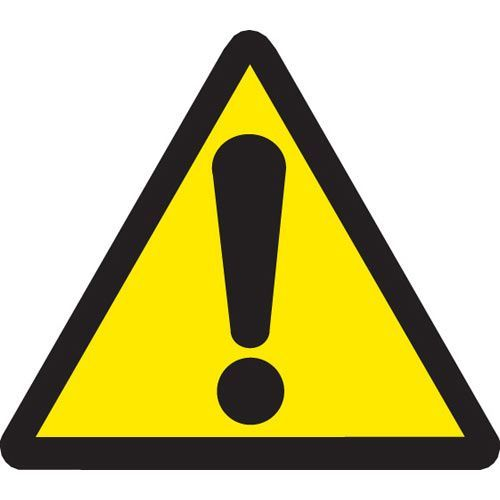

## WAIT -- DON'T RUN THE NEXT SECTION UNLESS YOU WANT TO QUERY THE APIs!

# 4/ Run subgraph queries for selected wallets

These queries are configured in the `utils` directory.

Some of these queries can take a long time to execute. Test them out by only using a small subset of wallets.

Each query will output a json file in `private_data/graphs` directory

In [13]:
# wallets = wallets[:500] # take a small subset of wallets for testing

## Lens Protocol
Determines if wallet has a profile minted on the Lens protocol

In [12]:
# test = query_lens(wallets[0:10])

j = execute_subgraph_query(
    api_function=query_lens, 
    list_of_wallets=wallets, 
    num_wallets_per_call=50,
    json_filepath=PATHS['graphs']['lens'],
    append_to_existing_file=False,
    return_json=True
)
print("Records:")
len(j['data'])

## POAP
Gathers basic info on how many POAPs a wallet has claimed (as well as up to 1000 event IDs).

In [14]:
# test = query_poaps_xdai(wallets[0:10])

j = execute_subgraph_query(
    api_function=query_poaps_xdai, 
    list_of_wallets=wallets, 
    num_wallets_per_call=100,
    json_filepath=PATHS['graphs']['poaps'],
    append_to_existing_file=False,
    return_json=True
)
print("Records:")
len(j['data'])

## Snapshot
Pulls relevant voting and DAO affiliations from Snapshot

In [15]:
# test = query_snapshot(wallets[0:10])

j = execute_subgraph_query(
    api_function=query_snapshot, 
    list_of_wallets=wallets, 
    num_wallets_per_call=100,
    json_filepath=PATHS['graphs']['snapshot'],
    append_to_existing_file=False,
    return_json=True
)
print("Records:")
len(j['data'])

## Zora / NFTs
Pulls relevant NFT data (on ETH only).

API has limit of 500 results per page, so this requires some creative batching to get (most) of the NFTs.

In [16]:
j = query_zora(
    wallets, 
    num_per_call=20,
    nfts_path=PATHS['graphs']['nfts'], 
    return_json=True
)
print("Records:")
len(j['data'])

## Proof of Humanity

Check the number of profiles [here](https://app.proofofhumanity.id/) and round up to the nearest 1000

In [17]:
num_profiles = 17000 

poh_addresses = get_raw_set_of_addresses(num_profiles)

with open(PATHS['graphs']['poh'], 'w') as outfile:
    json.dump(list(poh_addresses), outfile, indent=2)
print("Records:")
len(poh_addresses)

# / Scrap

Another approach, using a third party GraphQL client

In [18]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

sample_transport=RequestsHTTPTransport(
    url='https://api.thegraph.com/subgraphs/name/poap-xyz/poap-xdai',
    verify=True,
    retries=3,
)
client = Client(
    transport=sample_transport
)
query = gql('''
query poap {
  accounts(
    where: {
      id_in: ["0xffe296bbbc86dfac056b42c6180d9f8b4cb412aa"]
    }
  ) {
    id
    tokensOwned
    tokens (first: 1000) {
      event {
        id
      }
    }
  }
}
''')
response = client.execute(query)
print(response)